In [1]:
import pandas as pd
import janitor as jn
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from utils import ECDF
import arviz as az
import warnings

warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


# Learning Goals

In this notebook，you will: 

1. Continue to gain familiarity with describing the data generation process using PyMC3 probability distributions.
1. Explore a different probability distribution story using the Student T family of distributions.
1. Gain practice writing hierarchical models.

## Darwin's Finches

A research group has taken measurements of the descendants of the finches that Charles Darwin observed when he postulated the theory of evolution.

We will be using Bayesian methods to analyze this data, specifically answering the question of how quantitatively different two species of birds' beaks are.

**Data Credits:** The Darwin's finches datasets come from the paper, [40 years of evolution. Darwin's finches on Daphne Major Island][data]. 

One row of data has been added for pedagogical purposes.

[data]: (https://datadryad.org/resource/doi:10.5061/dryad.g6g3h). 


### Load Data
Let's get started and load the data.

In [2]:
from data import load_finches_2012
df = load_finches_2012()
df.sample(5)

,band,species,beak_length,beak_depth,species_enc
8,19104,fortis,10.3,8.4,0
210,21093,scandens,12.7,8.2,1
201,21040,scandens,14.1,9.8,1
136,19278,scandens,14.0,9.8,1
102,21262,fortis,10.1,8.0,0


**Note:** I have added one row of data, simulating the discovery of an "unknown" species of finch for which beak measurements have been taken.

For pedagogical brevity, we will analyze only beak depth during the class. However, I would encourage you to perform a similar analysis for beak length as well.

In [3]:
fortis_df = df.query("species == 'fortis'")
scandens_df = df.query("species == 'scandens'")
unknown_df = df.query("species == 'unknown'")

In [4]:
fortis_df.shape, scandens_df.shape, unknown_df.shape

((121, 5), (127, 5), (1, 5))

=> Only one data point for unknown!

### Model Building

We are going to build an estimation model for finch beaks.

**Discussion:** Let's think a bit about the data generation process for finch beaks.

- What is a reasonable likelihood for the data?
- Given that likelihood, what are reasonable distribution (just their names, not their parameter values yet) that we can choose to describe those parameters? (Hint: Think about what are biologically *valid* ranges for finch beaks.)
- Given those distributions, what would be reasonable parameter values to describe these hyperpriors?

**Exercise:** Recreate the estimation model for finch beak depths. A few things to note:

- Practice using numpy-like fancy indexing.
- Difference of means & effect size are optional.
- Feel free to disagree with the crowd.

If it helps, try drawing out the model.

Student T distn <= generalization of normal and cauchy
* normal:  really low prob in tail 
* cauchy:  high prob in tail
* dof==1 in student T => cauchy
* dof==infinity in student T => normal


Student's t-distribution becomes the Cauchy distribution when the degrees of freedom is equal to one and converges to the normal distribution as the degrees of freedom go to infinity. 

In [5]:
with pm.Model() as beak_depth_model:
    # Beaks cannot be of "negative" mean, therefore, HalfNormal is 
    # a reasonable, constrained prior.
    mean = pm.HalfNormal('mean', sd=10, shape=(3,))
    
    # Define the prior for the observed variance of the beak depths
    sd = pm.HalfCauchy('sd', beta=50, shape=(3,))
    
    # Define the nuisance parameter nu for the T distribution
    nu = pm.Exponential('nu', lam=1/29., shape=(3,)) + 1
    
    # Define the likelihood.
    like = pm.StudentT('likelihood', 
                       nu=nu[df['species_enc']],
                       mu=mean[df['species_enc']], 
                       sd=sd[df['species_enc']], 
                       observed=df['beak_depth']
                      )

### Sample from Posterior

In [6]:
with beak_depth_model:
    trace = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [nu, sd, mean]
100%|██████████| 3000/3000 [00:18<00:00, 160.36it/s]
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


### Visualize Posterior Densities

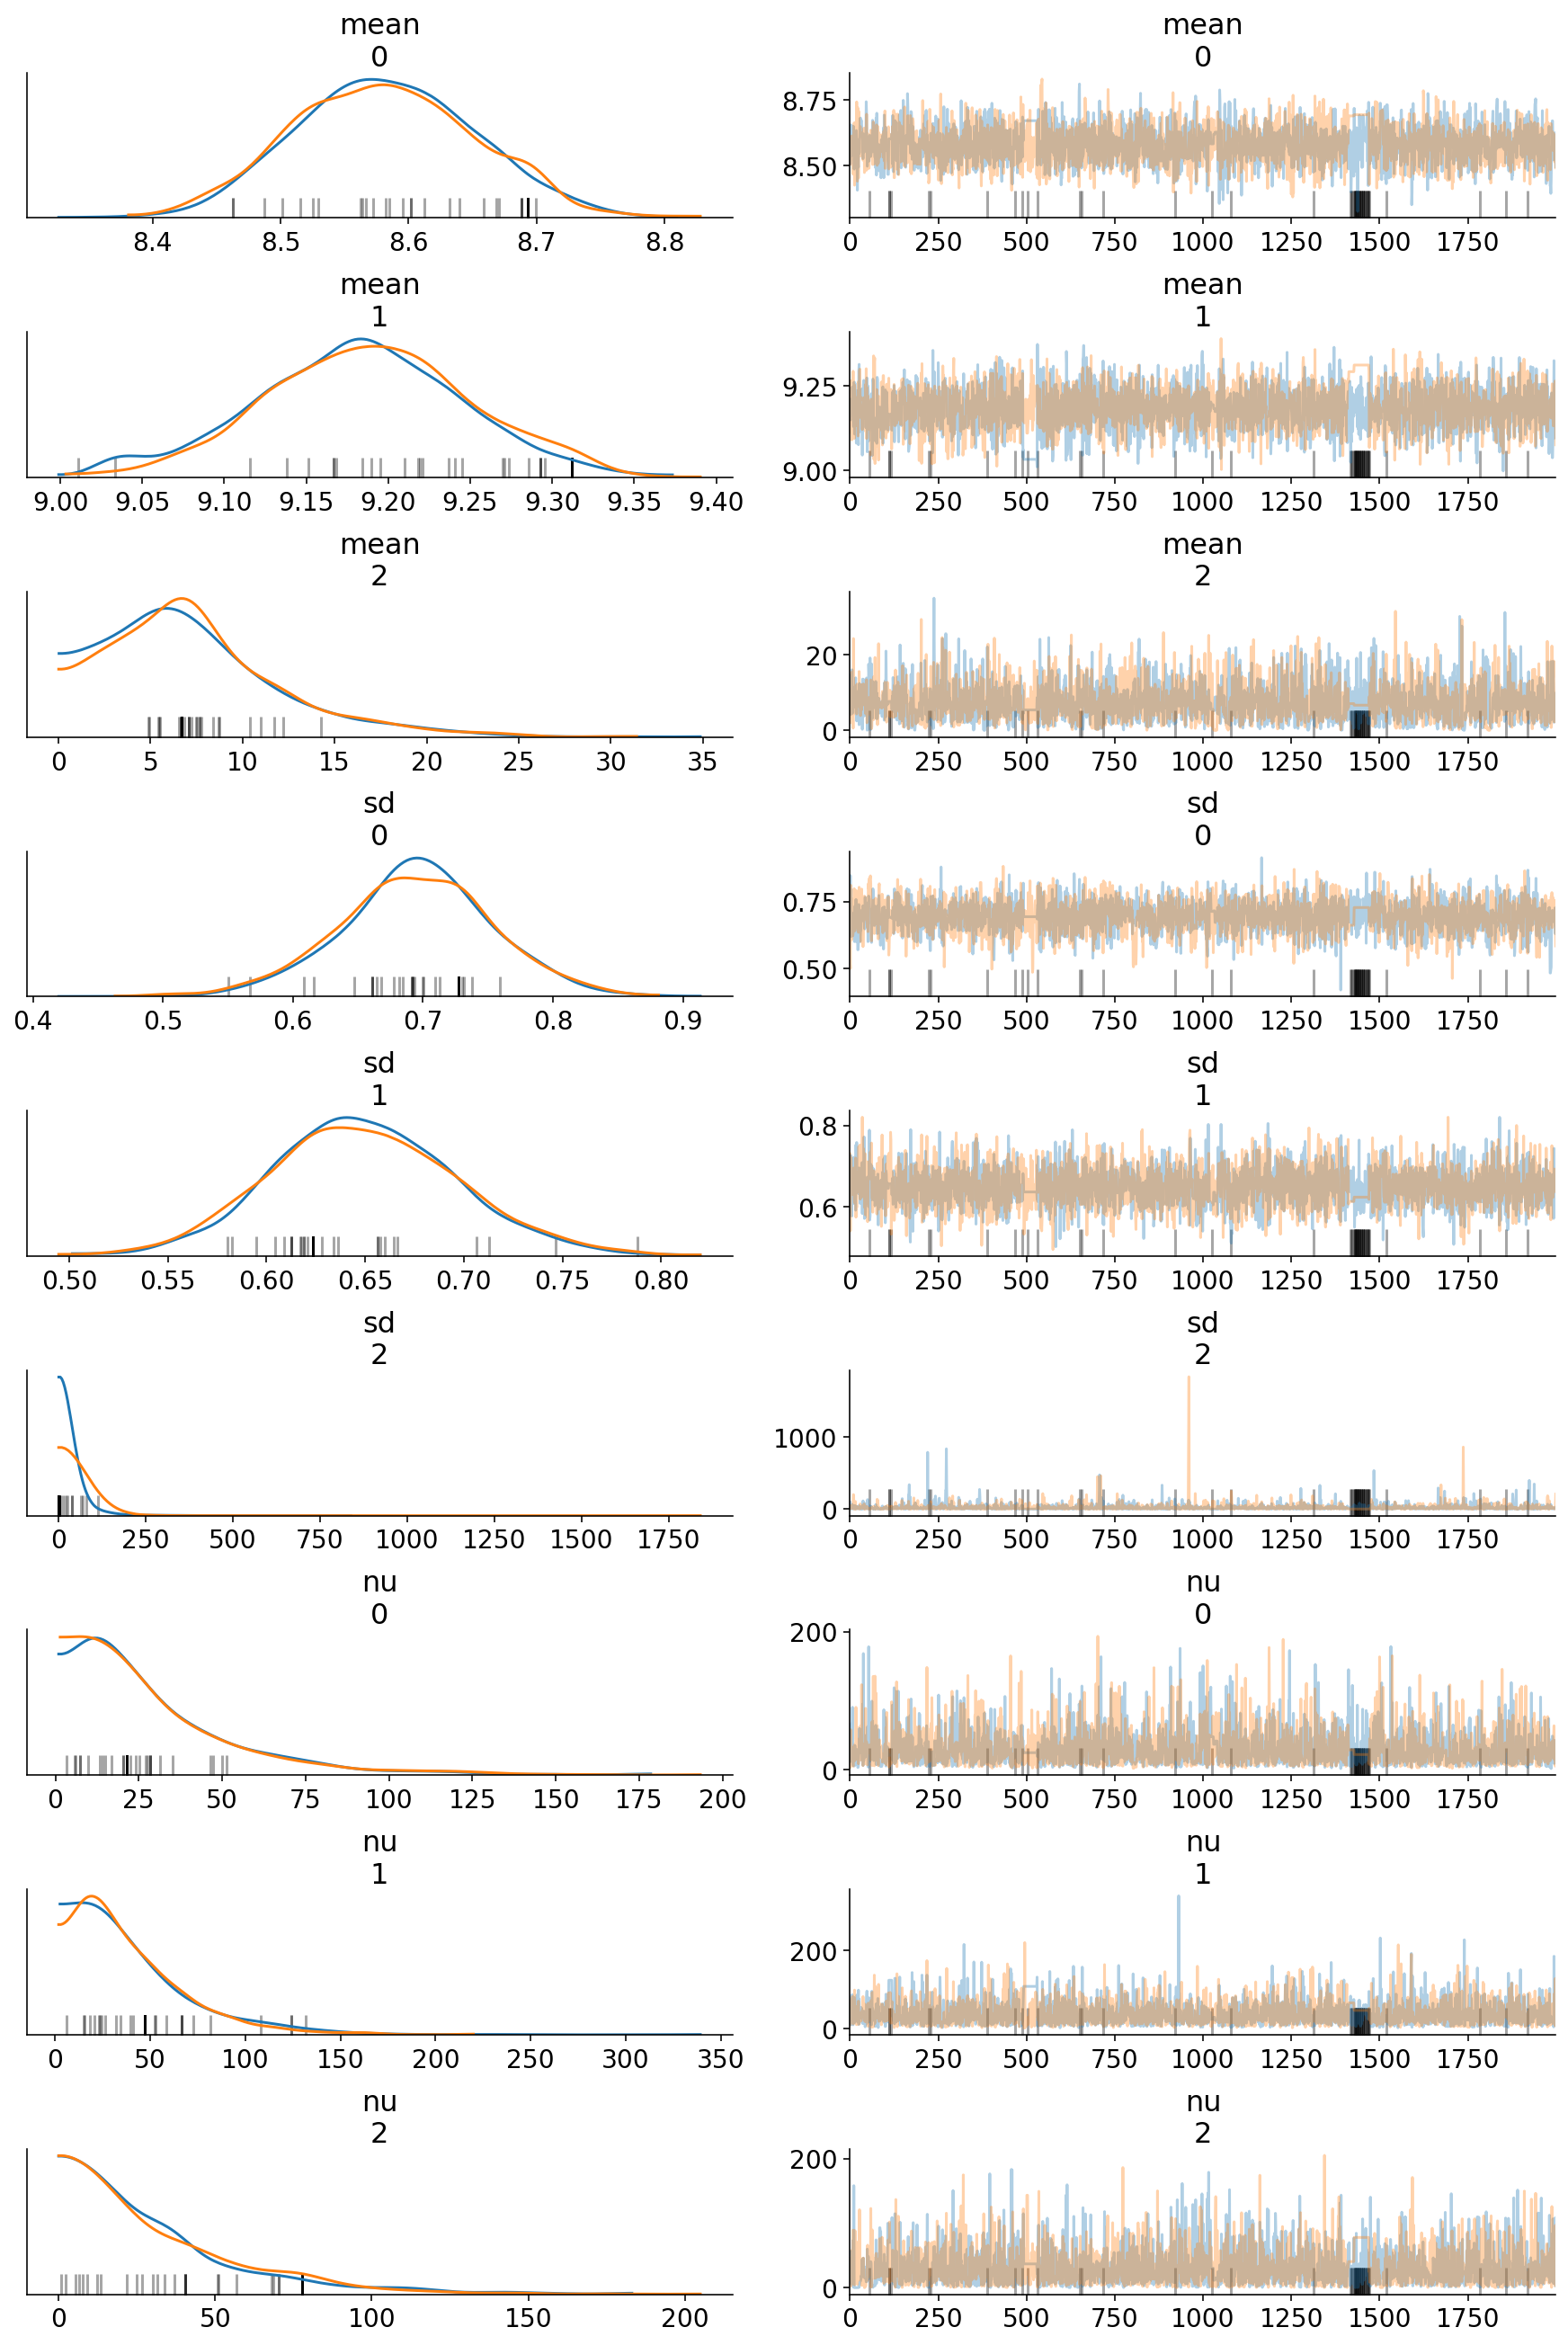

In [7]:
# Plot the sample trace.
traces = az.plot_trace(trace)

Visualize the posterior distribution over the population "mean" parameter using the forest plot.

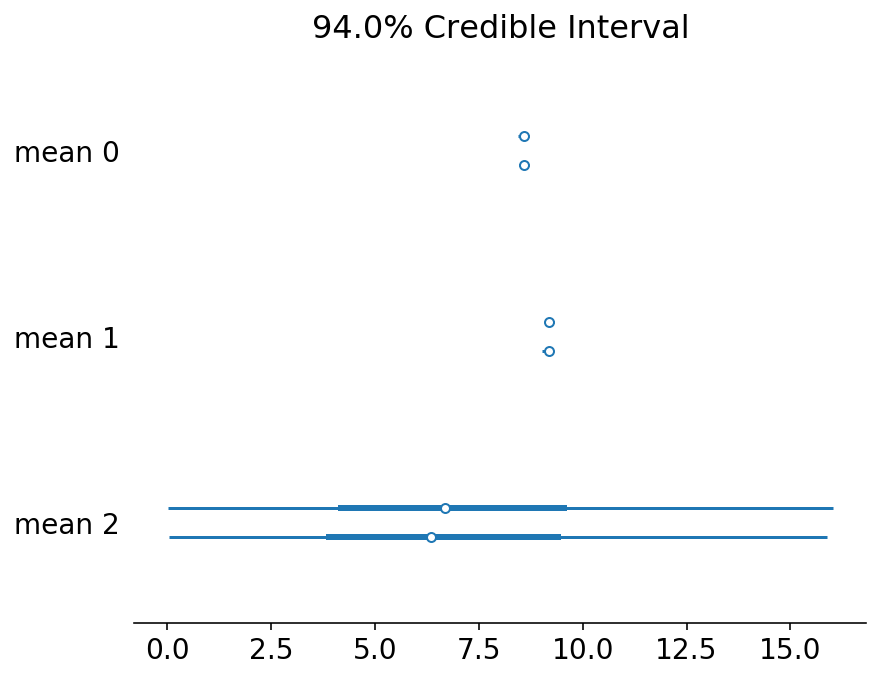

In [8]:
az.plot_forest(trace, var_names=['mean']);

Visualize the posterior distribution of the means using `plot_posterior`.

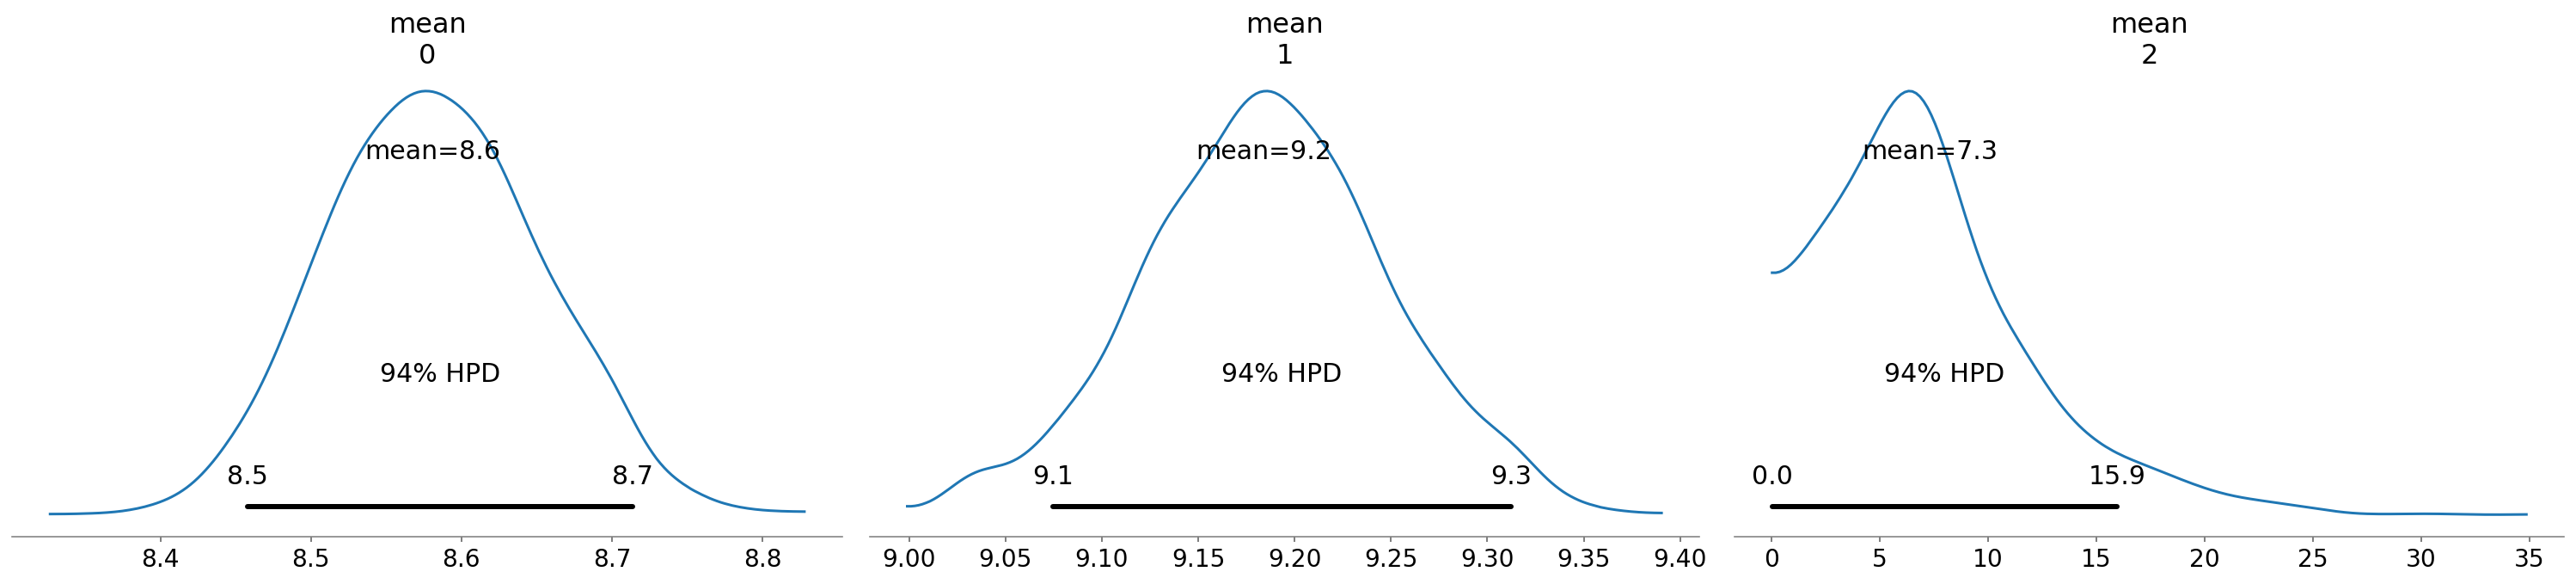

In [9]:
az.plot_posterior(trace, var_names=['mean']);

**Discuss:**
- Is the posterior distribution of beaks for the unknown species reasonable?

Answer: No. It shows that it ranges from 0 to 15. Normally, it goes from 4 ~ 9 or similar.

### Code-along: Posterior Predictive Check

We will now introduce you to the posterior predictive check. The premise behind this check is that if your model describes the data generating process well, then sampling new data from the data likelihood should give you simulated data that looks like the original data.

In [10]:
samples = pm.sample_ppc(trace, model=beak_depth_model, samples=2000)

100%|██████████| 2000/2000 [00:05<00:00, 355.26it/s]


Hint: Each column in the samples (key: "likelihood") corresponds to simulated measurements of each finch in the dataset. We can use fancy indexing along the columns (axis 1) to select out simulated measurements for each category, and then flatten the resultant array to get the full estimated distribution of values for each class.

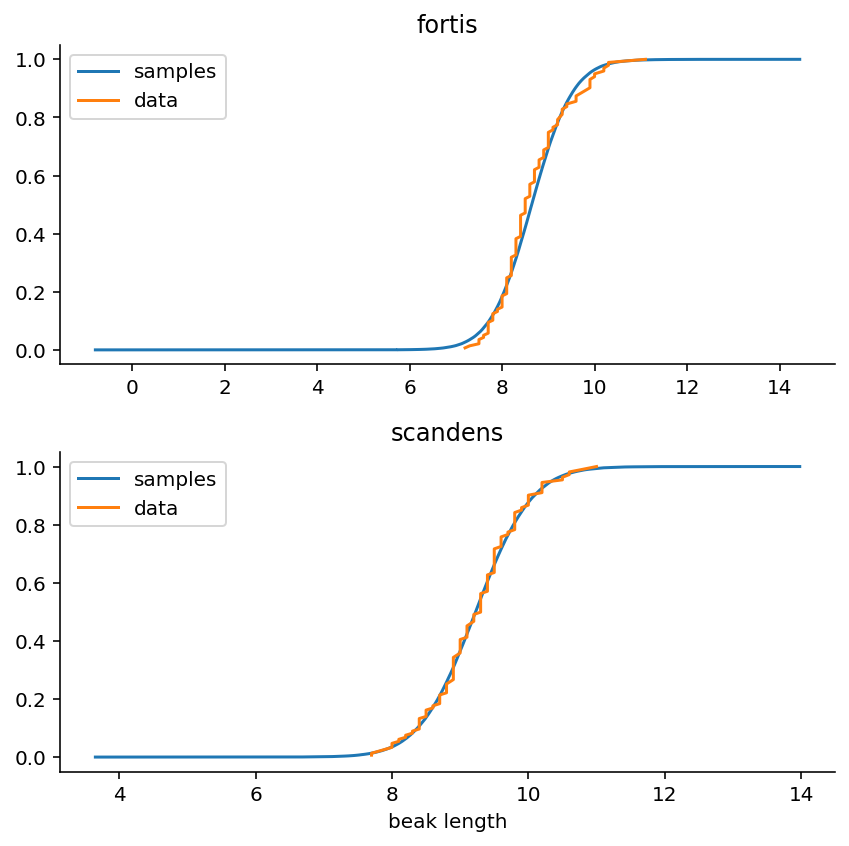

In [11]:
def plot_samples_ecdf(ax, group_data, samples):
    # Extract just the fortis samples.
    group_samples = samples['likelihood'][:, group_data.index].flatten()
    # Compute the ECDF for the fortis samples.
    x_s, y_s = ECDF(group_samples)
    ax.plot(x_s, y_s, label='samples')
    
def plot_data_ecdf(ax, group_data):
    # Compute the ECDF for the fortis samples
    x, y = ECDF(group_data['beak_depth'])
    ax.plot(x, y, label='data')

    
def ax_polish(ax, title):
    ax.legend()
    ax.set_title(title)
    
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 6))

ax_fortis, ax_scandens = axes[0], axes[1]

plot_samples_ecdf(ax_fortis, fortis_df, samples)
plot_samples_ecdf(ax_scandens, scandens_df, samples)

plot_data_ecdf(ax_fortis, fortis_df)
plot_data_ecdf(ax_scandens, scandens_df)

ax_polish(ax_fortis, 'fortis')
ax_polish(ax_scandens, 'scandens')
ax_scandens.set_xlabel('beak length')

plt.tight_layout()

### Model Critique

Compare the samples (blue line) to the data (orange line).

1. What's similar?
1. What's different?
1. What modelling choices might be contributing to the differences? How might we modify the model to minimize the difference?

Also, think about the reasonable-ness of the estimates for the "unknown" species. Is it reasonable?

## Finches Model Rebuild

We're going to do a second round of model building, this time incorporating two key ideas:

1. We want a hierarchical model, because estimates for the "unknown" species fall into the *unreasonable* range. We may want to make this claim because we are relying on other information that we did not bake into the model.
1. The Student T distribution may be okay, but a Normal distribution likelihood might be better. Alternatively, we may want to put a prior on the degree of freedom parameter that biases it towards higher values, hence achieving a similar effect as imposing a Normal distribution likelihood. (We would encourage you doing the former, as the latter involves more modelling choices.)

### Hands-On: Model Building

Attempt to build the hierarchical model according to the aforementioned pointers.

In [12]:
# One workflow is to build the model backwards. Start with the likelihood, and 
# work backwards until you get to the hyperpriors.
with pm.Model() as hierarchical_finches:
    
    # Step 3: Define hyperpriors for the prior distribution parameters.
    prior_sig = pm.Exponential("prior_sig", lam=5.)
    mu = pm.HalfNormal("mu", sd=prior_sig, shape=(3,))
    
    # Step 2: Define prior distributions on the likelihood parameters.
    # Ensure that they have the correct shape.
    prior_lam = pm.Exponential("prior_lam", lam=1.)
    sigma = pm.Exponential("sigma", lam=prior_lam, shape=(3,))
    
    # Step 1: Define likelihood. Don't forget to do broadcasting!
    like = pm.Normal(
        "likelihood", 
        mu=mu[df['species_enc']],
        sd=sigma[df['species_enc']],
        observed=df['beak_depth'],
    )   

### Sample from Posterior

In [14]:
with hierarchical_finches:
    trace_hierarchical = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, prior_lam, mu, prior_sig]
100%|██████████| 2500/2500 [00:25<00:00, 96.33it/s] 
There were 288 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6243868673509817, but should be close to 0.8. Try to increase the number of tuning steps.
There were 435 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


### Model Checking

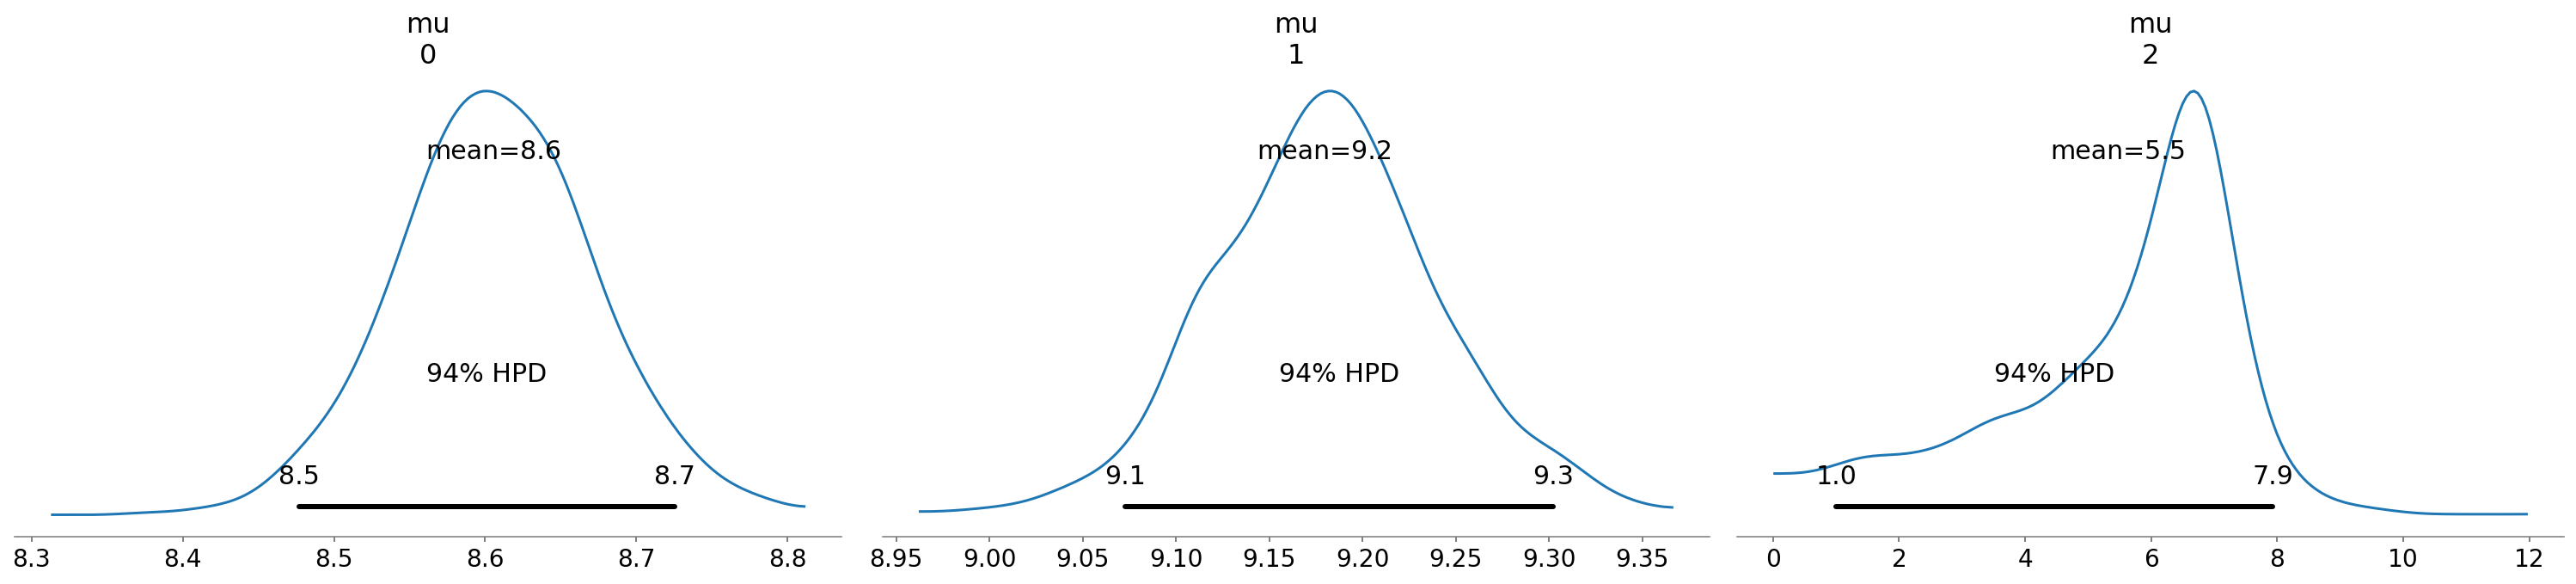

In [15]:
az.plot_posterior(trace_hierarchical, var_names=['mu']);

=> Now, it becomes more reasonable (1 ~ 8). Most of the crebilities are in 4 ~ 8

### Posterior Predictive Checks

Visualize how close our model is to the generated data.

In [16]:
samples_hierarchical = pm.sample_ppc(trace_hierarchical, 
                                     model=hierarchical_finches, 
                                     samples=2000)

100%|██████████| 2000/2000 [00:03<00:00, 541.70it/s]


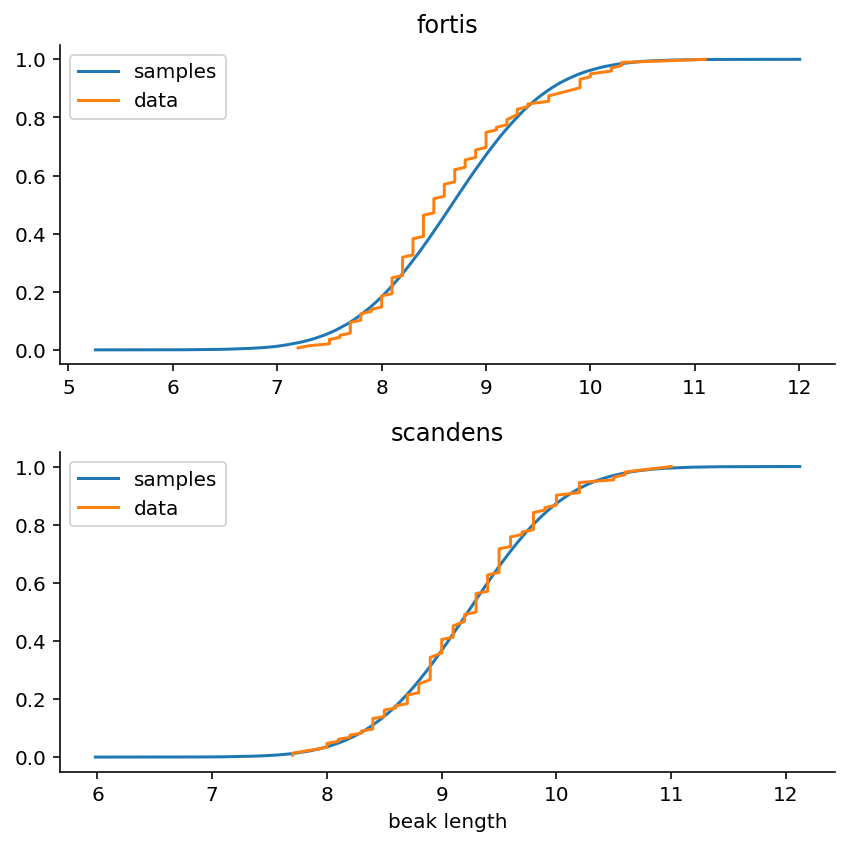

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 6))

ax_fortis, ax_scandens = axes[0], axes[1]

plot_samples_ecdf(ax_fortis, fortis_df, samples_hierarchical)
plot_samples_ecdf(ax_scandens, scandens_df, samples_hierarchical)

plot_data_ecdf(ax_fortis, fortis_df)
plot_data_ecdf(ax_scandens, scandens_df)

ax_polish(ax_fortis, 'fortis')
ax_polish(ax_scandens, 'scandens')
ax_scandens.set_xlabel('beak length')

plt.tight_layout()

### Model Critique

**Discussion:**

1. How reasonable are the new estimates for beak length for the unknown species, compared to the old estimates from the non-hierarchical model? Where is its distribution center of mass?
1. What about the variance estimates?
1. What does the posterior predictive check tell you about the goodness of the model?

## Summary

1. NumPy-like fancy indexing lets us write models in a concise fashion.
1. Posterior estimates can show up as being "unreasonable", "absurd", or at the minimum, counter-intuitive, if we do not impose the right set of assumptions on the model.
